# Inspecting .datx Files with datx2py

This notebook will:

1. Define the datx2py loader (recursively decodes an HDF5/.datx file into native Python).
2. Use it to load a file into a nested dict.
3. Walk that dict to extract every path, its type (group or dataset), shape/dtype (for datasets), and attributes.
4. Present the results in a Pandas DataFrame for easy browsing.

Next step is thinking about how to use some interferomtry package to visualize the data and extract values.


In [1]:
# Dependencies
import sys
import h5py
import json
import numpy as np
import pandas as pd

In [2]:
# %% Define datx2py loader

def datx2py(file_name):
    """Recursively decode an HDF5/.datx file into nested Python dicts/lists/scalars."""
    import h5py, numpy as np

    def _group2dict(obj):
        return {k: _decode_h5(v) for k, v in zip(obj.keys(), obj.values())}

    def _struct2dict(arr):
        names = arr.dtype.names
        return [dict(zip(names, _decode_h5(rec))) for rec in arr]

    def _decode_h5(obj):
        if isinstance(obj, h5py.Group):
            d = _group2dict(obj)
            if obj.attrs:
                d['attrs'] = _decode_h5(obj.attrs)
            return d
        elif isinstance(obj, h5py.AttributeManager):
            return _group2dict(obj)
        elif isinstance(obj, h5py.Dataset):
            out = {'attrs': _decode_h5(obj.attrs)}
            try:
                out['vals'] = obj[()]
            except (OSError, TypeError):
                pass
            return out
        elif isinstance(obj, np.ndarray):
            if np.issubdtype(obj.dtype, np.number) and obj.shape == (1,):
                return obj[0]
            if obj.dtype == 'object':
                return [_decode_h5(o) for o in obj]
            if np.issubdtype(obj.dtype, np.void):
                return _decode_h5(_struct2dict(obj))
            return obj
        elif isinstance(obj, np.void):
            return [_decode_h5(o) for o in obj]
        elif isinstance(obj, bytes):
            return obj.decode()
        elif isinstance(obj, (list, tuple)):
            return obj[0] if len(obj) == 1 else obj
        else:
            return obj

    with h5py.File(file_name, 'r') as f:
        return _decode_h5(f)

## 2. Load a .datx file

Update the `file_path` variable to point at your file.


In [3]:
# Example usage
file_path = '/Users/elbert/prysm_play/Single Pulse and Incremental Passes/3_Passes_S.datx'  # ← update this!
data_dict = datx2py(file_path)

print(f"Loaded top‐level keys: {list(data_dict.keys())}")

Loaded top‐level keys: ['Attributes', 'Data', 'MetaData', 'Processed Data: ']


## 3. Flatten the nested dict into a table of (path, type, shape, dtype, attrs)
Walk `data_dict` recursively, track each object’s HDF5‐style path, determine if it’s a group or dataset, and collect its metadata.


In [4]:
# Helper to walk nested dicts from datx2py
def walk_datx(obj, prefix=""):
    """
    Yields tuples (path, entry) where entry is either:
      - dict with keys 'vals' and 'attrs' → dataset
      - dict of sub‐entries (and optional 'attrs') → group
    """
    if not isinstance(obj, dict):
        return

    # if this dict represents a dataset (has 'vals' key)
    if 'vals' in obj:
        yield prefix.rstrip('/'), obj
    else:
        # group: first yield group itself if it has attrs
        yield prefix.rstrip('/'), obj
        # then recurse into children
        for k, v in obj.items():
            if k == 'attrs':  # skip treating attrs as child
                continue
            new_prefix = f"{prefix}/{k}"
            yield from walk_datx(v, new_prefix)

# Build rows
rows = []
for path, entry in walk_datx(data_dict, prefix=""):
    is_dataset = 'vals' in entry
    row = {
        'Path': path or "/",  
        'Type': 'Dataset' if is_dataset else 'Group',
        'Shape': entry['vals'].shape if is_dataset else "",
        'Dtype': str(entry['vals'].dtype) if is_dataset else "",
        'Attrs': entry.get('attrs', {})
    }
    rows.append(row)

# Display a quick preview
pd.DataFrame(rows).head(10)

,Path,Type,Shape,Dtype,Attrs
0,/,Group,,,{}
1,/Attributes,Group,,,{'File Layout Version': 1}
2,/Attributes/System,Group,,,{}
3,/Attributes/{E3BF8957-E166-42EA-B867-5721D8DBD...,Group,,,"{'Data Context.Data Attributes.AGC': 0, 'Data ..."
4,/Data,Group,,,{}
5,/Data/Intensity,Group,,,{}
6,/Data/Intensity/{1E2DD1DE-52AA-4615-8FD3-A5A2F...,Dataset,"(1000, 1000)",int32,"{'Coordinates': {'RowStart': 0, 'ColumnStart':..."
7,/Data/Surface,Group,,,{}
8,/Data/Surface/{C491E902-5218-40AC-BE34-E4CA873...,Dataset,"(1000, 1000)",float64,"{'Coordinates': {'RowStart': 0, 'ColumnStart':..."
9,/Data/{3AD5CF24-EE4A-49B2-B550-DAEF948C76A6},Dataset,"(1024,)",uint8,{}


## 4. Serialize attributes and show full table

Convert NumPy types or bytes in `Attrs` to JSON‐friendly forms. JSON Python dicts, NumPy arrays, NumPy scalars, and byte‐strings are not directly JSON‐serializable so you need to handle that so you can call json.dumps(). This is handy for browsing and reporting, but if there are attributes you want to use in calculations or analysis it may be better to use the original dicts/array values.


In [5]:
# Cell 9: Serialize attributes and show full table

def serialize(v):
    if isinstance(v, dict):
        return {k: serialize(val) for k, val in v.items()}
    if isinstance(v, np.ndarray):
        return serialize(v.tolist())
    if isinstance(v, (list, tuple)):
        return [serialize(x) for x in v]
    if isinstance(v, np.generic):
        return v.item()
    if isinstance(v, bytes):
        return v.decode(errors='ignore')
    return v

# Build final DataFrame
final_rows = []
for r in rows:
    attrs = serialize(r['Attrs'])
    final_rows.append({
        'Path': r['Path'],
        'Type': r['Type'],
        'Shape': r['Shape'],
        'Dtype': r['Dtype'],
        'Attrs': json.dumps(attrs, ensure_ascii=False)
    })

df = pd.DataFrame(final_rows)
df

,Path,Type,Shape,Dtype,Attrs
0,/,Group,,,{}
1,/Attributes,Group,,,"{""File Layout Version"": 1}"
2,/Attributes/System,Group,,,{}
3,/Attributes/{E3BF8957-E166-42EA-B867-5721D8DBD...,Group,,,"{""Data Context.Data Attributes.AGC"": 0, ""Data ..."
4,/Data,Group,,,{}
5,/Data/Intensity,Group,,,{}
6,/Data/Intensity/{1E2DD1DE-52AA-4615-8FD3-A5A2F...,Dataset,"(1000, 1000)",int32,"{""Coordinates"": {""RowStart"": 0, ""ColumnStart"":..."
7,/Data/Surface,Group,,,{}
8,/Data/Surface/{C491E902-5218-40AC-BE34-E4CA873...,Dataset,"(1000, 1000)",float64,"{""Coordinates"": {""RowStart"": 0, ""ColumnStart"":..."
9,/Data/{3AD5CF24-EE4A-49B2-B550-DAEF948C76A6},Dataset,"(1024,)",uint8,{}


## Experiment with library

In [6]:
from prysm.interferogram import Interferogram
from prysm.sample_data import sample_files

/Users/elbert/miniconda3/envs/prysm/lib/python3.13/site-packages/prysm/__init__.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution


In [7]:
interf = Interferogram.from_zygo_dat(file_path)

(<Figure size 640x480 with 2 Axes>, <Axes: >)

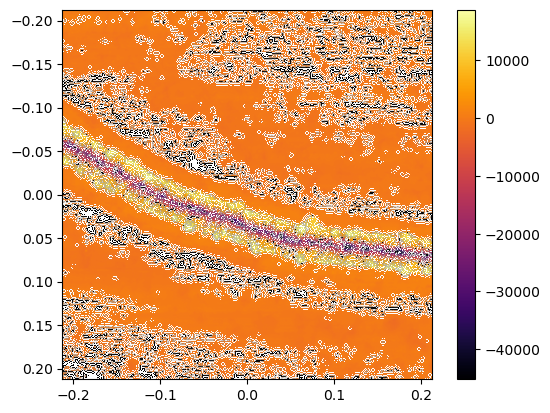

In [8]:
interf.plot2d()

(<Figure size 640x480 with 2 Axes>, <Axes: >)

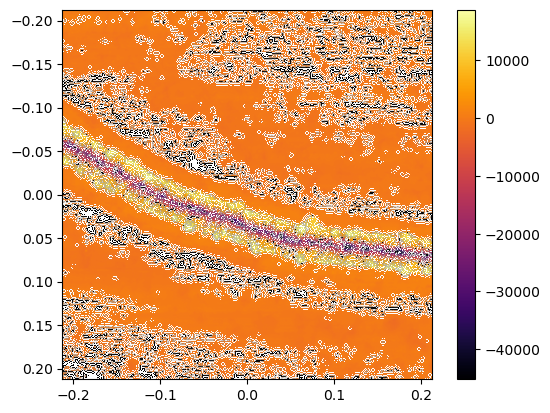

In [9]:
from prysm.geometry import circle

interf.recenter()
interf.mask(circle(12, interf.r))
interf.plot2d()

(<Figure size 640x480 with 2 Axes>, <Axes: >)

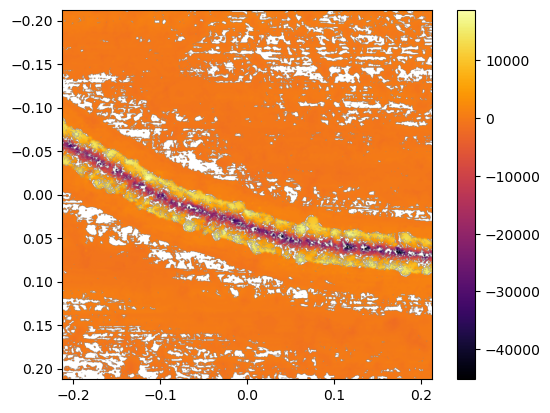

In [10]:
interf.crop()
interf.plot2d(interpolation='bilinear')

(<Figure size 640x480 with 2 Axes>, <Axes: >)

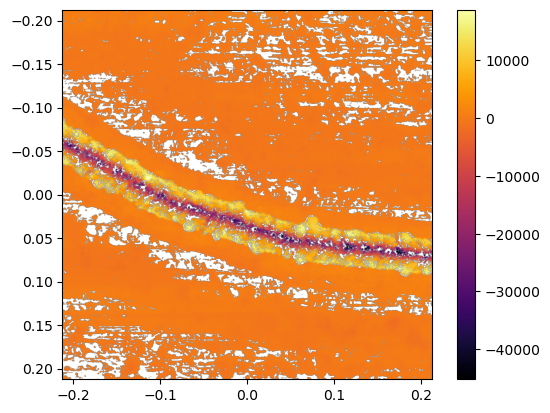

In [11]:
interf.recenter()
interf.remove_piston()
interf.remove_tiptilt()
interf.remove_power()
interf.plot2d(interpolation='bilinear')

In [12]:
interf.pv, interf.rms # units are nm

(np.float64(64003.204413700674), np.float64(3862.2845182229257))

In [13]:
w = interf.wavelength * 1e3 # wavelength is in microns
w/interf.pv, interf.rms

(np.float64(0.009376305208389855), np.float64(3862.2845182229257))